###**Importing Libraries**

In [1]:
# Import necessary libraries
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
import tensorflow as tf  # Import TensorFlow
from tensorflow.keras import layers
from IPython import display

###**Load MNIST Data**

In [2]:
# Load and preprocess the MNIST dataset
# MNIST dataset contains 60,000 training images of handwritten digits
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
train_images.shape

(60000, 28, 28)

### **Normalise and add channel as the dimension**

In [4]:
# Reshape and normalize the images
# Reshape to add the channel dimension and normalize pixel values to [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
print(train_images.shape)

(60000, 28, 28, 1)


###**Create a Buffer & Batch Size**

In [5]:
# Define buffer size and batch size
BUFFER_SIZE = 6000 # Size of the dataset
BATCH_SIZE = 256 # Batch Size of Training

###**Shuffle Images**

In [6]:
# Create batches of training data and shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

##**Generator Model**

In [7]:
# Function to build the generator model
def make_generator_model():
    model = tf.keras.Sequential()

    # First layer: Dense layer to project the input noise vector (latent space) to a higher-dimensional space
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    # Batch normalization helps stabilize training by normalizing the outputs of the previous layer
    model.add(layers.BatchNormalization())
    # LeakyReLU activation to allow a small gradient when the unit is not active
    model.add(layers.LeakyReLU())

    # Reshape the output to a 7x7x256 tensor
    model.add(layers.Reshape((7, 7, 256)))
    # The output shape is (batch_size, 7, 7, 256)
    # assert model.output_shape == (None, 7, 7, 256)

    # First transposed convolutional layer
    # Upsamples the input to a larger feature map
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # Output shape: (batch_size, 7, 7, 128)
    # assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second transposed convolutional layer
    # Upsamples to 14x14
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # Output shape: (batch_size, 14, 14, 64)
    # assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final transposed convolutional layer
    # Upsamples to 28x28, matches the MNIST image size
    # tanh activation scales the output to [-1, 1]
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')) # normalised image.
    # use this normalised image into descriminator again.
    # if you are not using tanh, hten you have to normalise before giving it to discriminator.
    # Output shape: (batch_size, 28, 28, 1)
    # assert model.output_shape == (None, 28, 28, 1) # should be the same as the real data shape

    return model

# Instantiate the generator model
generator = make_generator_model()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

###**Generate a random Latent Vector & Visualize**

In [8]:
# Generate a sample image to test the generator
noise = tf.random.normal([1, 100]) # Generate random noise vector
print(noise)

tf.Tensor(
[[-0.4905931  -0.45128623 -1.241406    0.8529409  -0.08082187  0.55481696
   0.56808734 -0.40947267  0.16409157 -0.3741637   0.882059    1.0797864
   0.17382413 -0.45554572  1.7283752   0.84170675 -1.2394655   0.27336293
  -1.369375   -0.5815343  -1.116357    0.24500264  0.16917256 -1.0728943
  -0.33759776  0.3837693   0.9623372  -0.32125294  1.1390567   0.03921172
   2.0512533  -1.6771839   0.63764244  0.507185    0.42172992 -0.41369632
   0.05103232 -0.7780171   0.4680385  -0.59749806  0.4095264  -1.2472017
  -0.2945831   1.4998895   1.9112328  -0.80999845  0.5770431   2.6598294
  -1.2233635  -0.41117027 -0.6573178  -0.7267762   2.0609634  -0.40226987
  -0.5324056   1.0047501   0.5762674  -0.9104437  -0.7232916   0.82352763
  -0.72035307 -0.25223836 -0.51040983 -1.5897005   0.1257935  -0.44913375
  -0.23407656 -0.2832638  -0.24743684 -0.9930033   0.31988493 -0.83465433
  -0.88510525  0.47139606 -1.026294    0.14878747 -0.9336125   0.6023665
   1.1388744   1.9502112   1.139

In [9]:
# Generate a sample image to test the generator
generated_image = generator(noise, training = False) # Generate image from noise

In [10]:
generated_image.shape

TensorShape([1, 28, 28, 1])

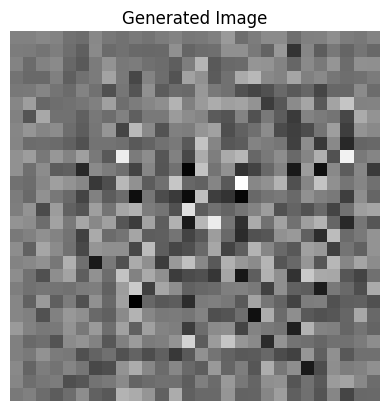

In [11]:
# Display the Generated Image
plt.imshow(generated_image[0, :, :, 0], cmap = 'gray')
plt.title("Generated Image")
plt.axis('off')
plt.show()

##**Discriminator Model**

In [12]:
# Function to build the discriminator model
def make_discriminator_model():
  model = tf.keras.models.Sequential()

  # First convolutional layer
  # Downsamples the input image
  model.add(layers.Conv2D(64, (5, 5), strides = (2, 2), padding = 'same', input_shape = [28, 28, 1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Second convolutional layer
  model.add(layers.Conv2D(128, (5, 5), strides = (2, 2), padding = 'same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Flatten the output and add a final dense layer for classification
  model.add(layers.Flatten())
  # Output layer without activation function (logits)
  model.add(layers.Dense(1)) # sigmoid activaiton funcution becuase we have only real or fake images.

  return model

In [13]:
# Instantiate Descriminator Model
discriminator = make_discriminator_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

###**Pass Generated Image on Discriminator Model**

In [15]:
# Test the discriminator on the generated image
decision = discriminator(generated_image)
print("Discriminator output:", decision)

Discriminator output: tf.Tensor([[-0.00199939]], shape=(1, 1), dtype=float32)


###**Define the loss function**

In [16]:
# Binary crossentropy loss is used since we have a binary classification problem (real or fake)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

## **Discrimanator's Loss**
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

- Discriminator.
- You pass real images and clauclate loss. ( real loss  ) - You pass labels as 1
- You pass fake images and clauclate loss. ( Fake loss ) - You pass labels as 0
- Real loss + fake loss.
- Total Loss

In [17]:
# Discriminator loss function
def discriminator_loss(real_output, fake_output):
  # Compute loss on real images (should be classified as 1)
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # class 1 for real
  # Compute loss on fake images (should be classified as 0)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # class 0 for Fake
  # Total discriminator loss
  total = real_loss + fake_loss
  return total

## **Generator Loss**
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

- Discrimnator ( effectively classify both )
 - real - Class 1
 - fake - Class 0
 fake_loss + real+loss = Total loss



- Generator ( effectively genrate image such that they are almost real )

- cross_entropy(tf.Zeros_like(fake_output), fake_output)  # zero is fake images.
- cross_entropy(tf.Ones_like(fake_output), fake_output)  # zero is fake images.

In [18]:
# Generator loss function
def generator_loss(fake_output):
  # Generator tries to fool the discriminator, so we want the fake images to be classified as real (1)
  return cross_entropy(tf.ones_like(fake_output), fake_output) # classifying 1

###**Intialize Optimizers**

In [19]:
# Define optimizers for both generator and discriminator
# Adam optimizer is commonly used for its adaptive learning rate and momentum
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# The discriminator and the generator optimizers are different since you will train two networks separately.

In [20]:
# Set up checkpointing to save the models during training
checkpoint_dir = './training_checkpoints'  # Directory to save checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Ensure the checkpoint directory exists
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)

# Create a checkpoint object to manage all the objects to be saved
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 desciriminator = discriminator)

In [21]:
# Set training parameters
EPOCHS = 100               # Number of epochs to train
noise_dim = 100           # Dimension of the noise vector (latent space)
num_examples_to_generate = 16  # Number of examples to generate for visualization

# Seed for generating images to visualize progress
# Using the same seed allows us to see how the generated images evolve over time
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

- for evry epoch.
    - generate some bunch of random noise.
    - convert random noise into image using generator.
    - You sample fake and real images.
    - train discriminator.
    - call discrinimatior loss
    - calculate generator loss
    - Update the both generator and discriimnator.

In [22]:
noise = tf.random.normal([BATCH_SIZE, noise_dim])

In [23]:
generated_image = generator(noise, training = False)

###**Define the training step function**

In [24]:
# @tf.function to compile the function for faster execution
@tf.function
def train_step(images):
  # Generate random noise for input to the generator
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  # Record operations for automatic differentiation
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # Generate fake images from the noise
    generated_images = generator(noise, training = True)

    # Get the discriminator's predictions on real and fake images
    real_output = discriminator(images, training = True)
    # fake_output contains the discriminator's predictions on the fake images.
    fake_output = discriminator(generated_images, training = True)

    # Calculate losses for both generator and discriminator
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Calculate gradients for generator and discriminator
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Apply gradients to update the weights of generator and discriminator
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Putting It All Together
The train_step function performs the following actions in one training iteration:

- Generate Random Noise:

- Creates a batch of random noise vectors to feed into the generator.
- Generate Fake Images:

- Uses the generator to create fake images from the noise.
- Get Discriminator Predictions:

- Feeds real images and fake images into the discriminator to get predictions.
- Calculate Losses:

- Computes the loss for both the generator and discriminator based on their performance.
- Compute Gradients:

- Calculates how the weights should be adjusted to minimize the losses.
- Update Weights:

- Adjusts the weights of both the generator and discriminator using the computed gradients and their respective optimizers.

In [25]:
# Function to generate and save images during training
def generate_and_save_images(model, epoch, test_input):
  # Set training=False to ensure that all layers run in inference mode (e.g., dropout and batchnorm)
  predictions = model(test_input, training = False)

  # Rescale images from [-1, 1] to [0, 1] for display
  predictions = (predictions + 1) / 2.0

  # Set up the plot
  fig = plt.figure(figsize = (4, 4))

  # Generate Subplots for each image
  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[0, :, :, 0], cmap = 'gray')
    plt.axis('off')

  # Save the figure
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [26]:
# Training function to run the training loop
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    # Iterate over each batch of images
    for image_batch in dataset:
      train_step(image_batch)

    # Generate and save images to visualize progress
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time() - start))

    # Generate images after the final epoch
    # display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

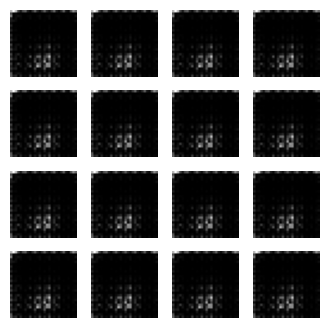

Time for epoch 1 is 22.38 sec


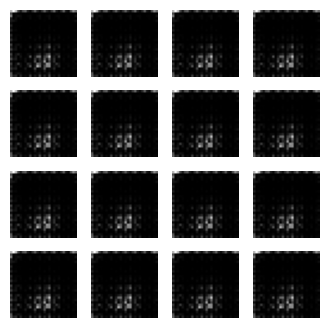

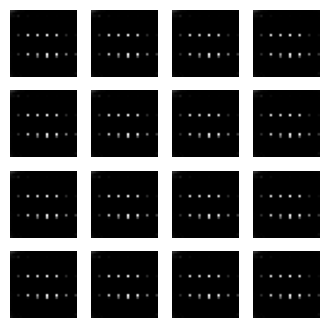

Time for epoch 2 is 12.39 sec


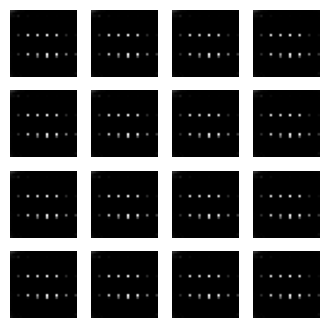

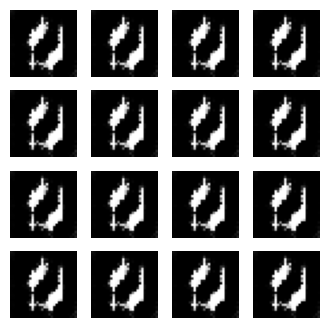

Time for epoch 3 is 13.68 sec


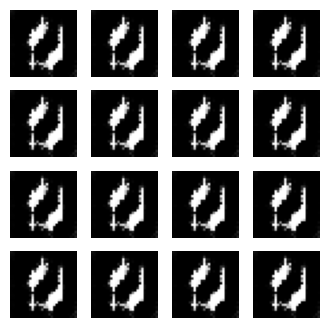

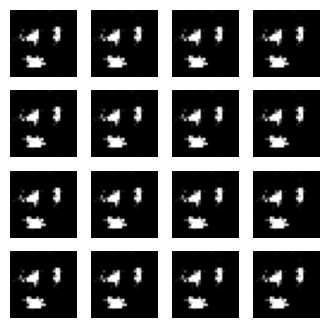

Time for epoch 4 is 12.51 sec


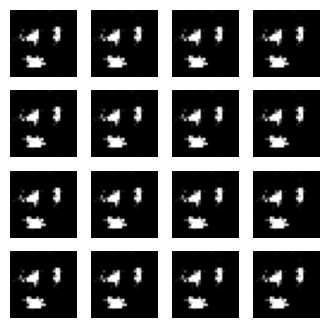

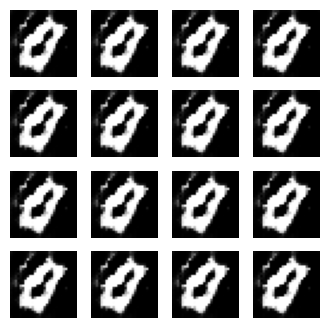

Time for epoch 5 is 12.33 sec


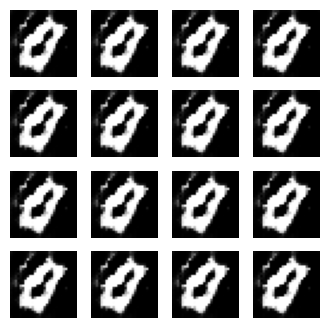

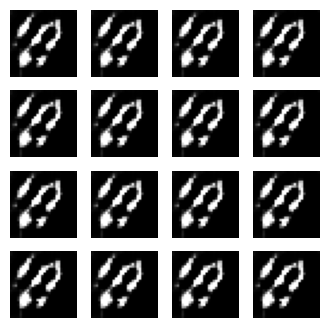

Time for epoch 6 is 12.21 sec


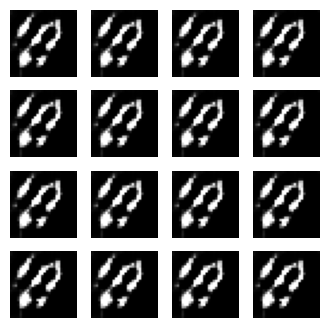

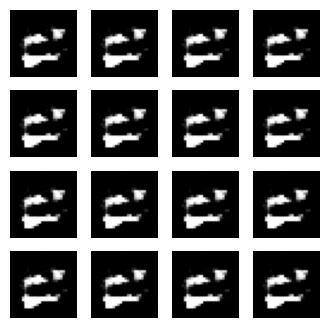

Time for epoch 7 is 12.11 sec


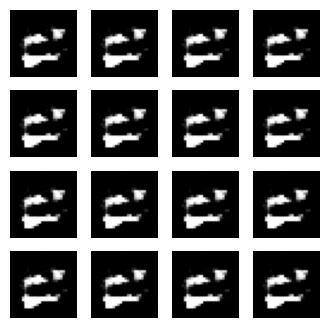

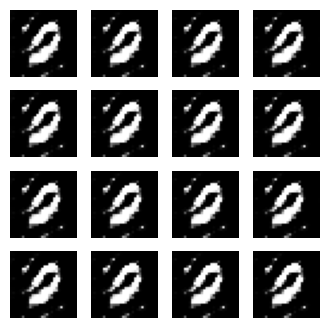

Time for epoch 8 is 12.16 sec


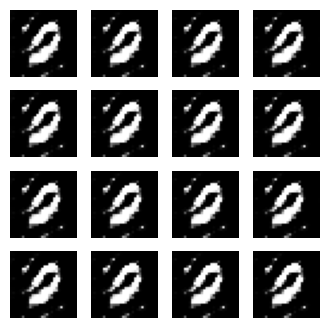

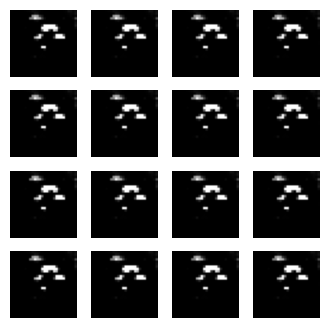

Time for epoch 9 is 12.18 sec


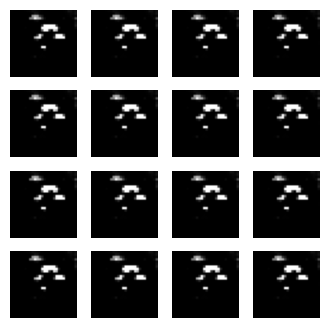

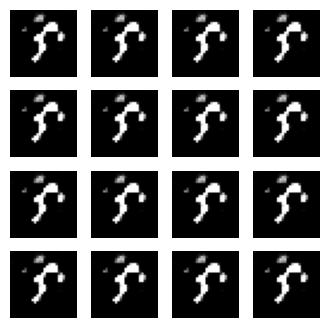

Time for epoch 10 is 12.26 sec


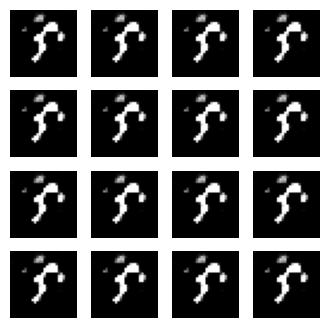

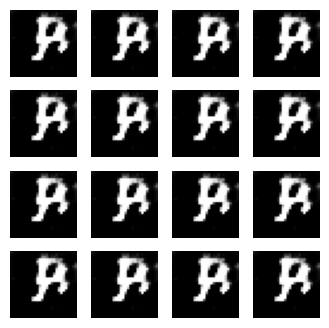

Time for epoch 11 is 12.29 sec


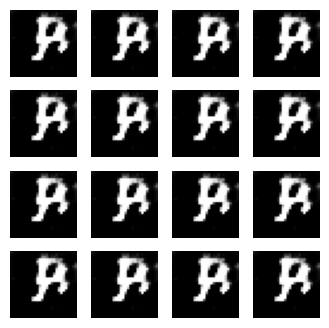

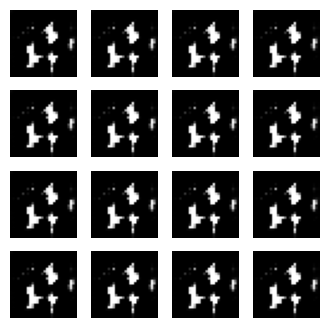

Time for epoch 12 is 12.29 sec


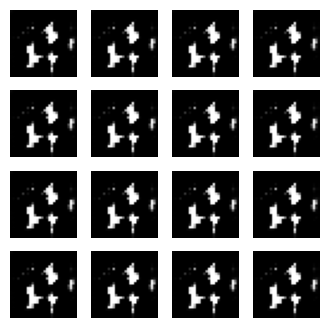

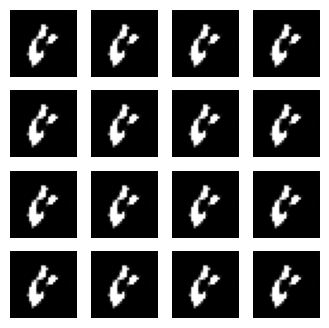

Time for epoch 13 is 12.21 sec


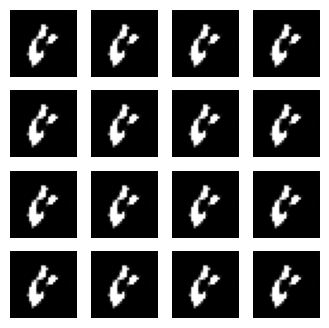

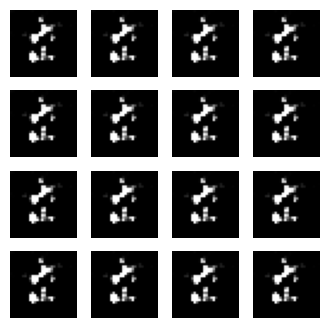

Time for epoch 14 is 12.45 sec


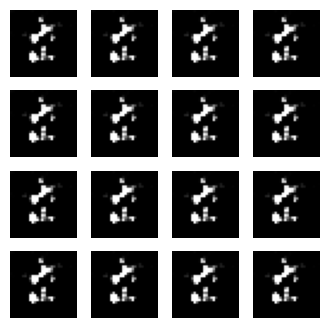

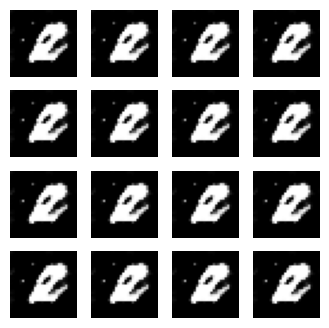

Time for epoch 15 is 12.35 sec


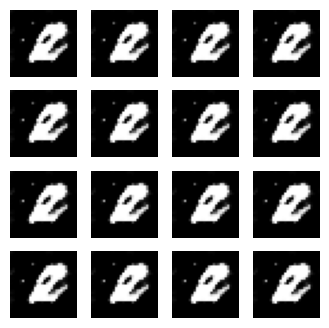

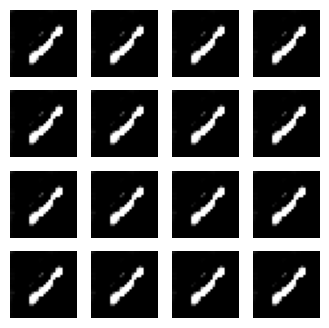

Time for epoch 16 is 12.65 sec


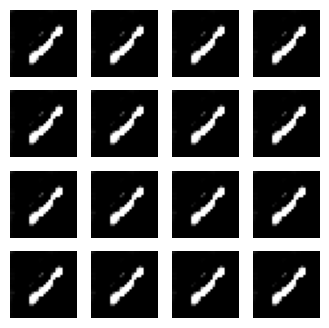

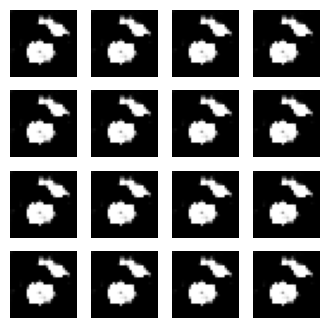

Time for epoch 17 is 12.41 sec


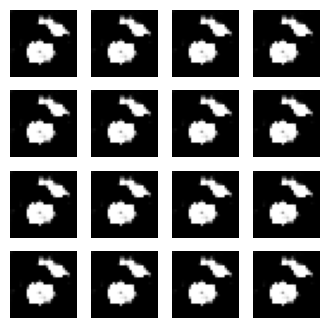

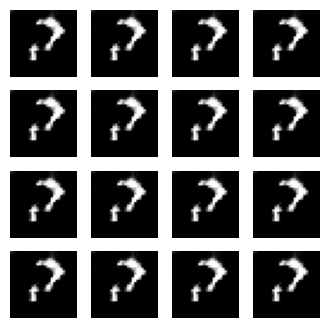

Time for epoch 18 is 12.74 sec


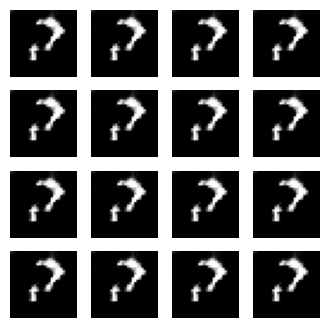

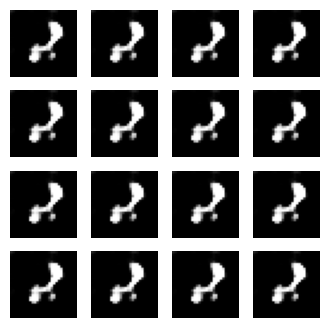

Time for epoch 19 is 12.25 sec


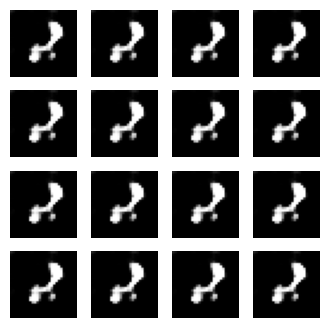

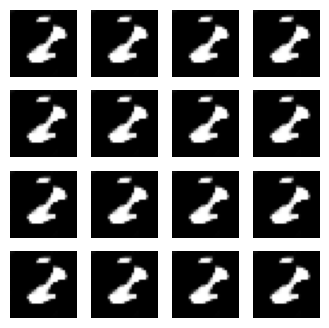

Time for epoch 20 is 12.47 sec


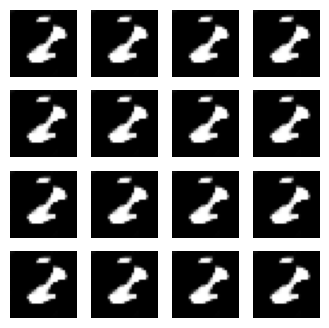

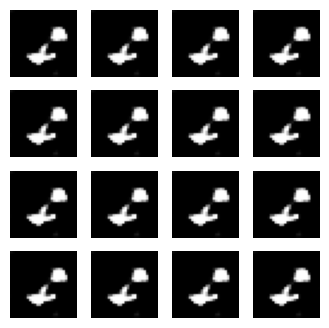

Time for epoch 21 is 12.22 sec


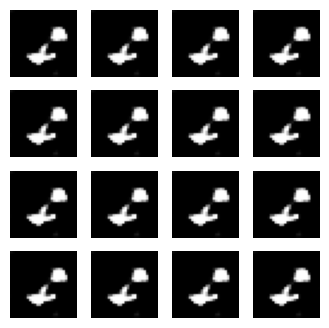

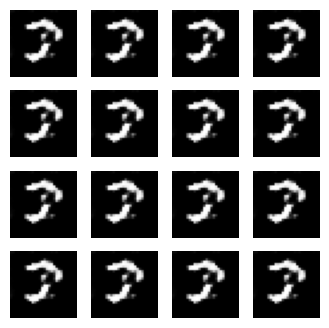

Time for epoch 22 is 12.45 sec


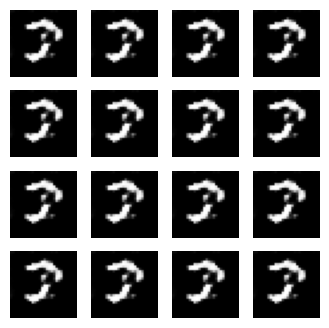

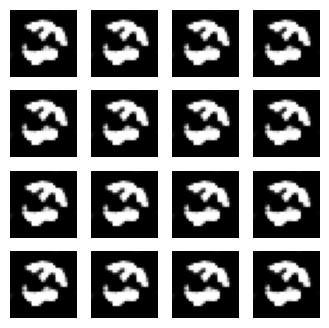

Time for epoch 23 is 12.21 sec


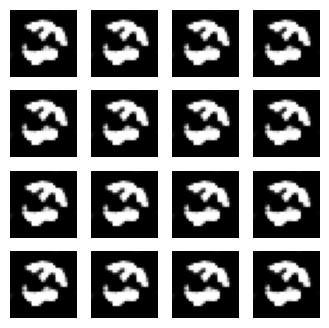

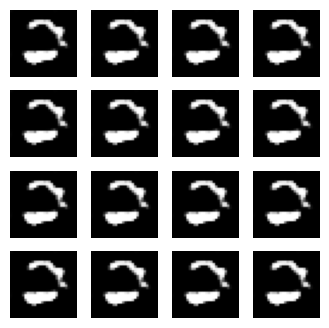

Time for epoch 24 is 12.20 sec


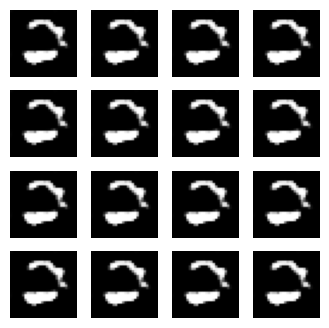

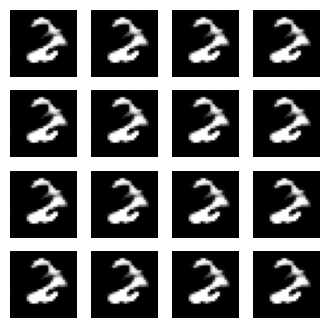

Time for epoch 25 is 12.22 sec


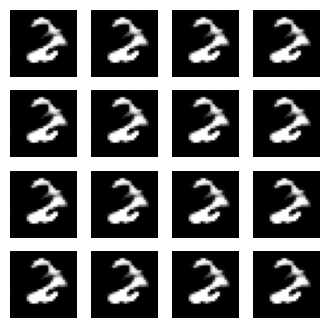

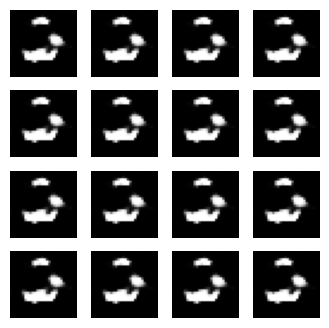

Time for epoch 26 is 12.22 sec


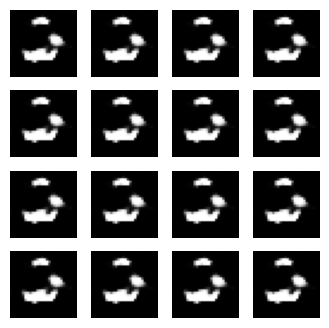

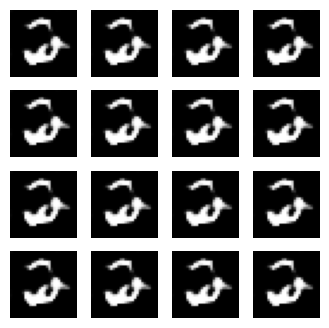

Time for epoch 27 is 12.22 sec


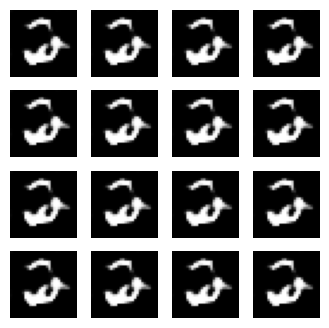

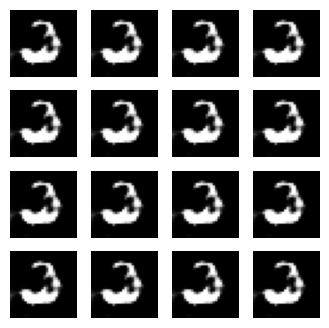

Time for epoch 28 is 12.21 sec


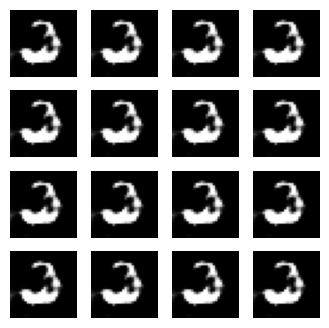

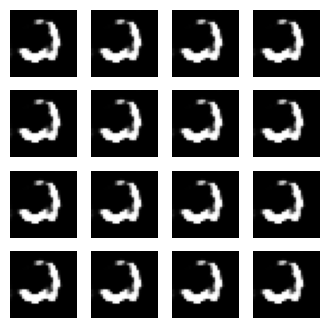

Time for epoch 29 is 12.23 sec


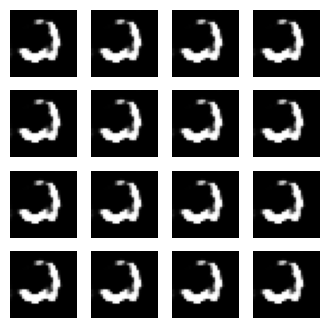

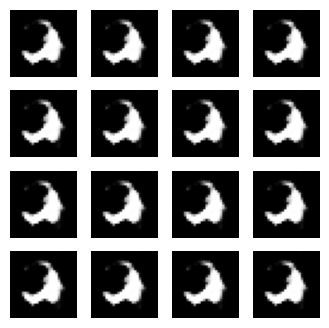

Time for epoch 30 is 12.36 sec


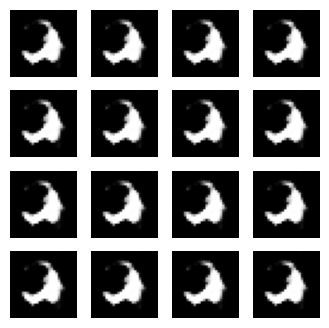

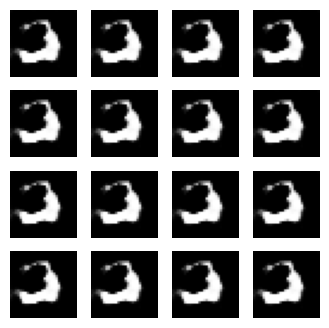

Time for epoch 31 is 12.23 sec


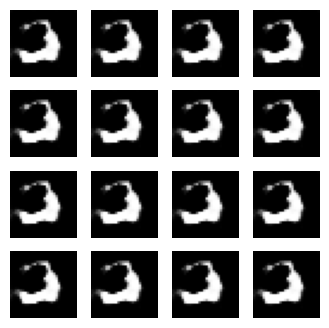

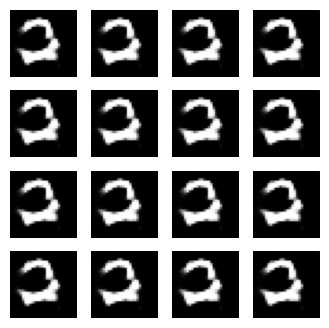

Time for epoch 32 is 12.42 sec


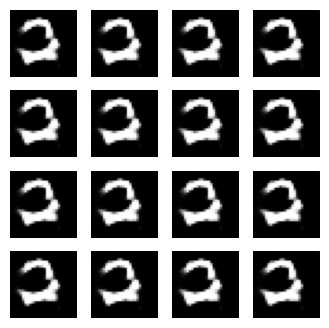

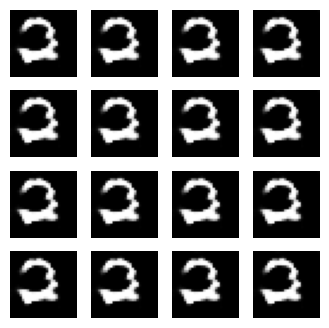

Time for epoch 33 is 12.80 sec


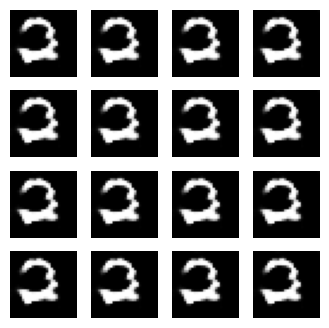

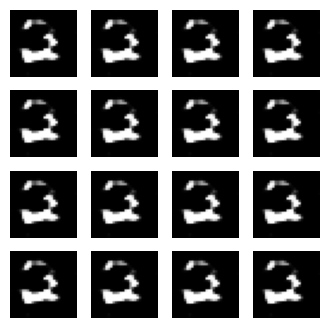

Time for epoch 34 is 12.54 sec


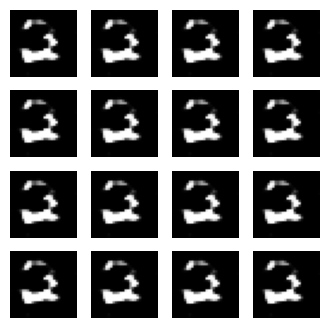

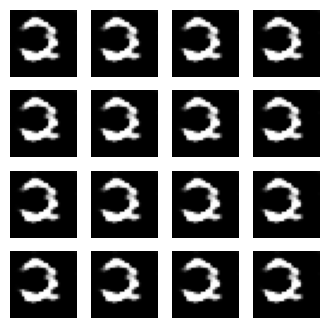

Time for epoch 35 is 12.50 sec


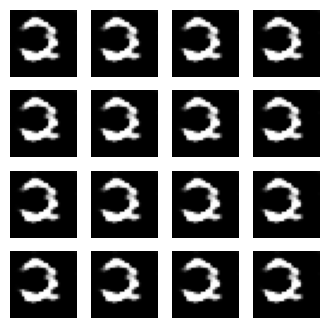

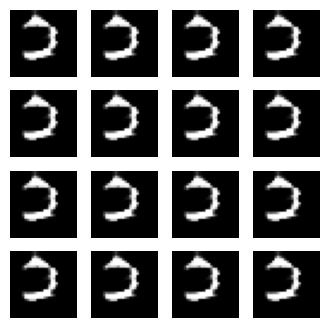

Time for epoch 36 is 12.22 sec


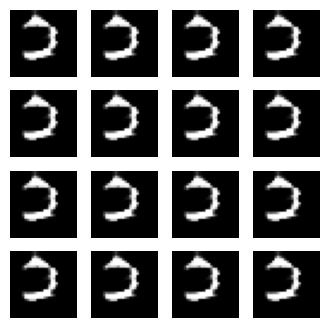

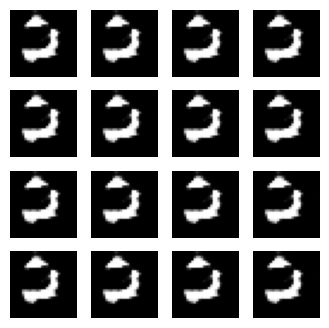

Time for epoch 37 is 12.48 sec


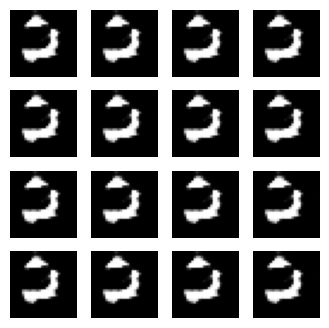

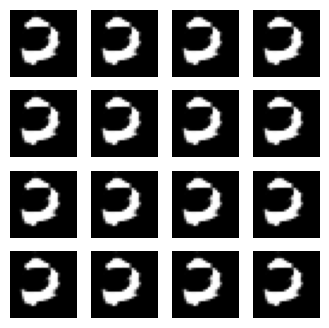

Time for epoch 38 is 12.24 sec


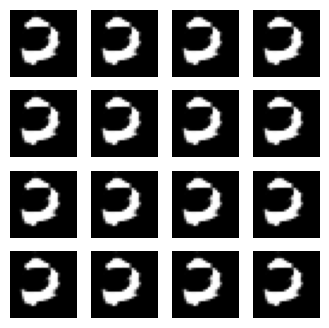

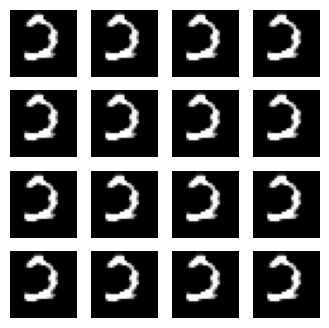

Time for epoch 39 is 12.53 sec


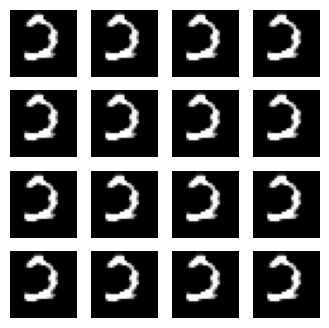

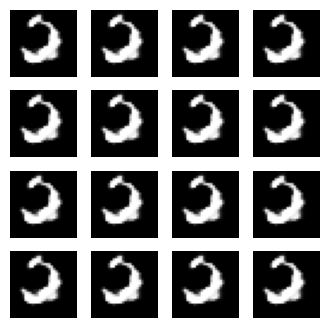

Time for epoch 40 is 12.23 sec


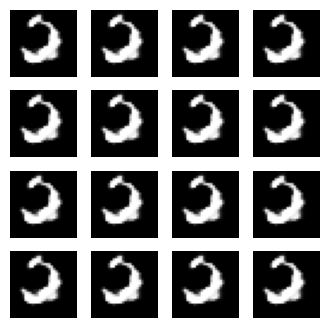

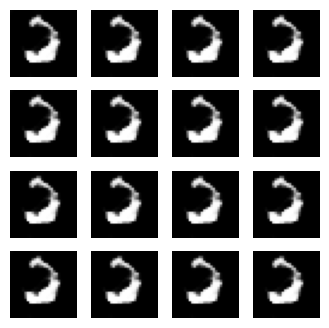

Time for epoch 41 is 12.23 sec


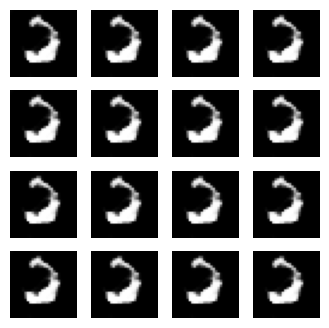

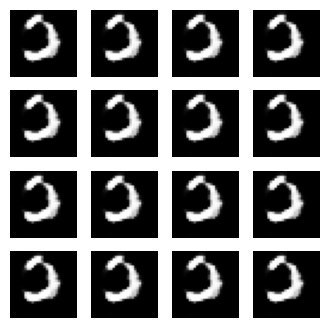

Time for epoch 42 is 12.22 sec


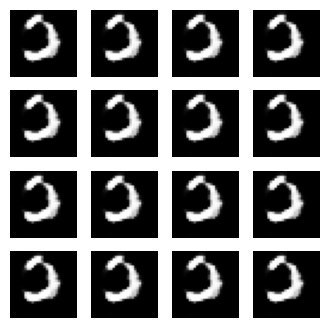

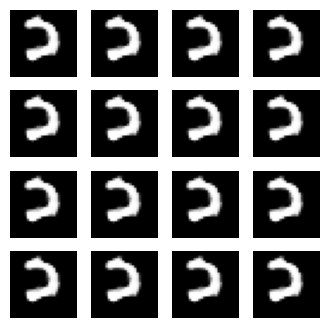

Time for epoch 43 is 12.24 sec


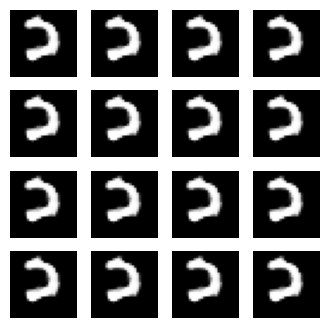

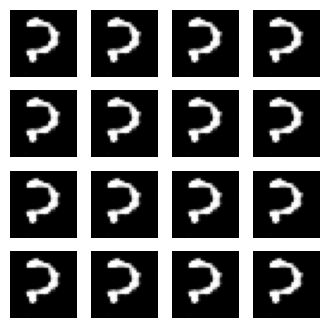

Time for epoch 44 is 12.25 sec


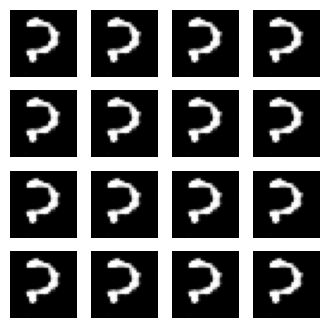

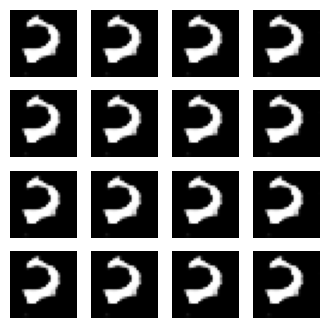

Time for epoch 45 is 12.42 sec


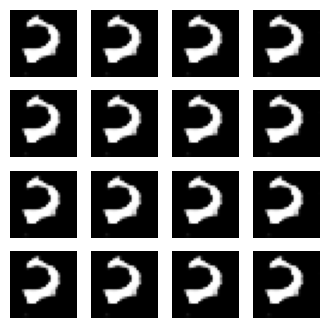

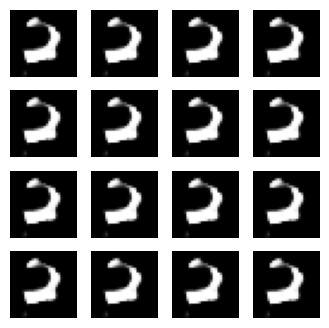

Time for epoch 46 is 12.22 sec


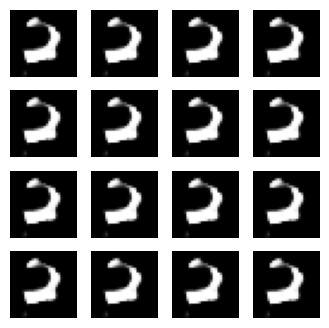

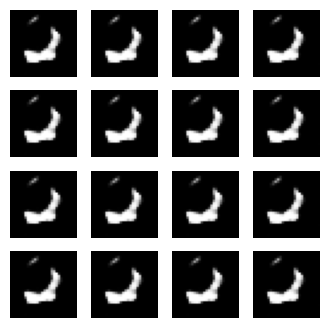

Time for epoch 47 is 12.24 sec


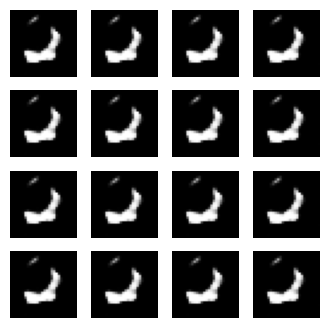

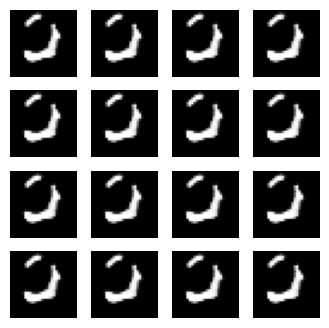

Time for epoch 48 is 12.43 sec


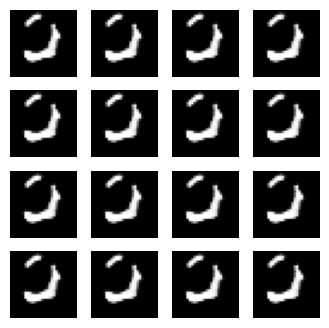

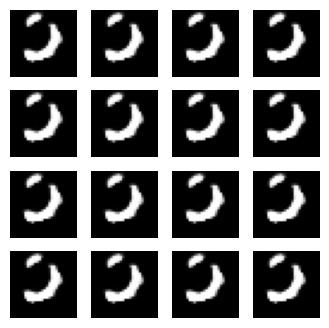

Time for epoch 49 is 12.44 sec


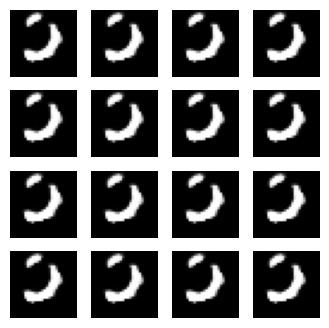

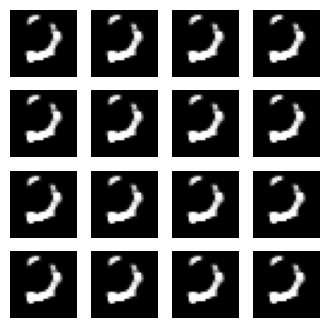

Time for epoch 50 is 12.22 sec


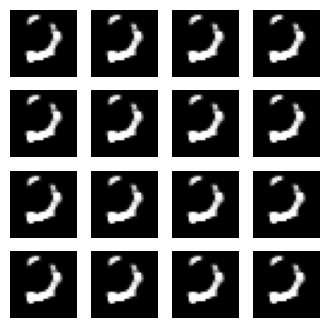

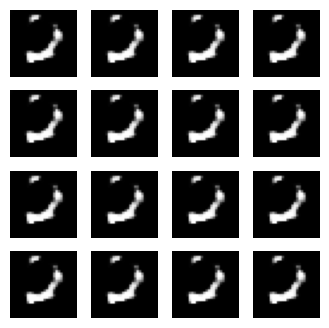

Time for epoch 51 is 12.22 sec


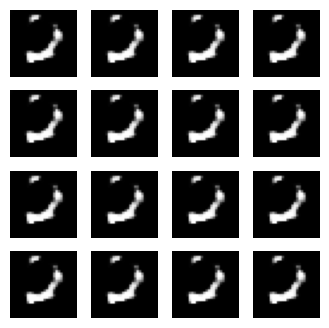

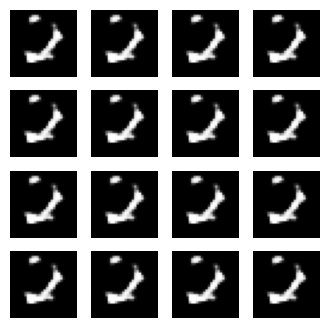

Time for epoch 52 is 12.50 sec


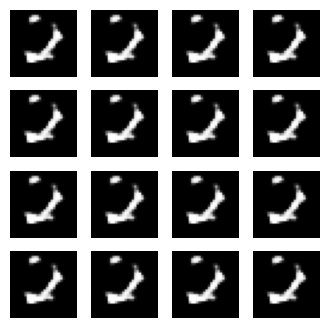

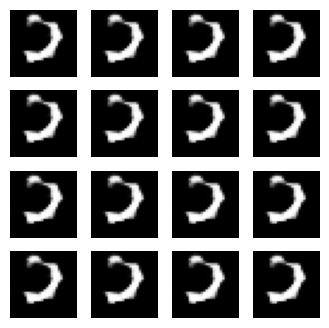

Time for epoch 53 is 12.23 sec


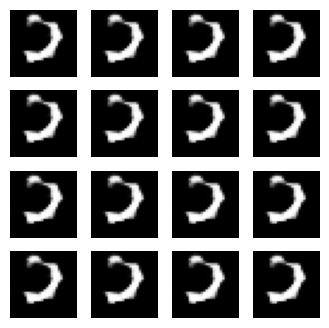

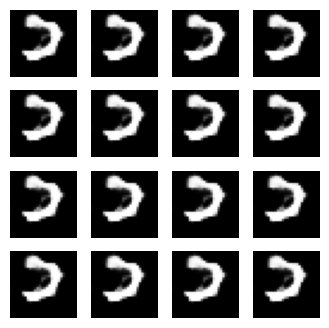

Time for epoch 54 is 12.46 sec


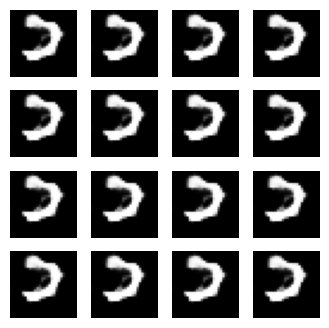

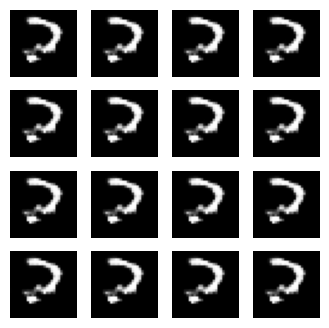

Time for epoch 55 is 12.24 sec


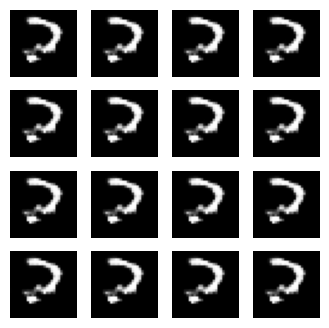

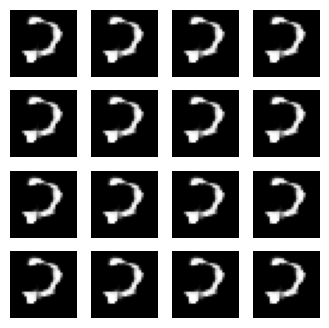

Time for epoch 56 is 12.49 sec


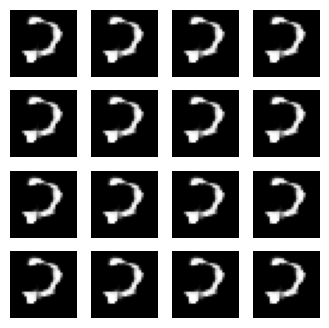

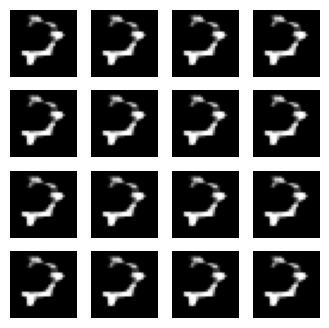

Time for epoch 57 is 12.22 sec


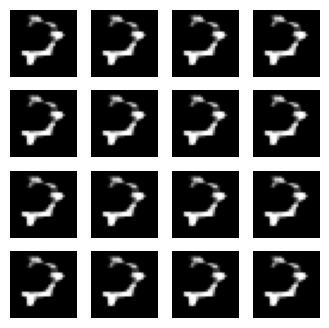

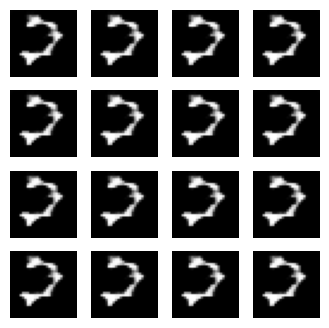

Time for epoch 58 is 12.47 sec


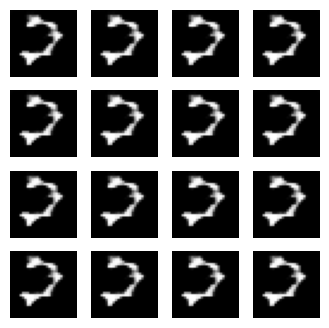

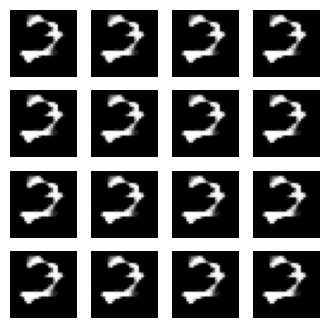

Time for epoch 59 is 12.22 sec


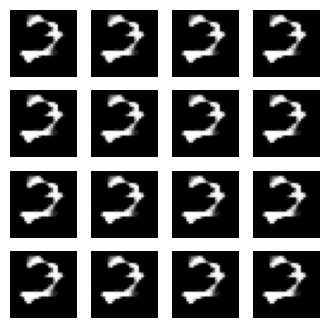

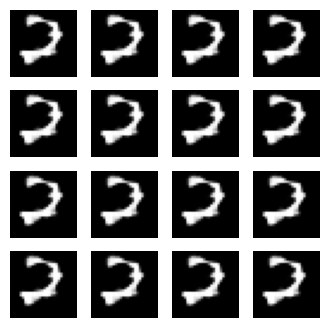

Time for epoch 60 is 12.37 sec


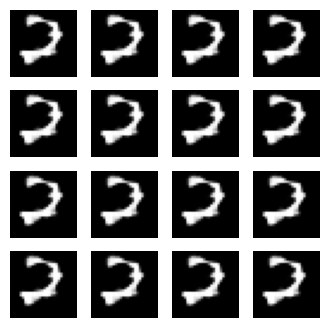

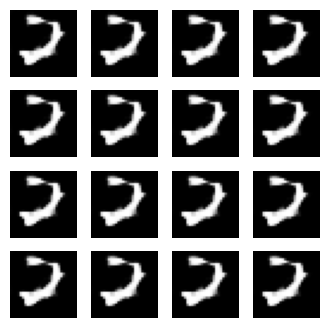

Time for epoch 61 is 12.25 sec


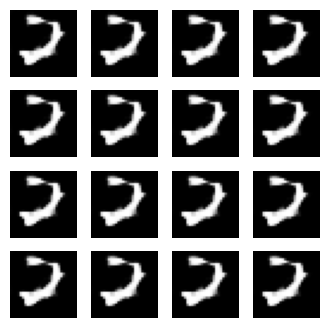

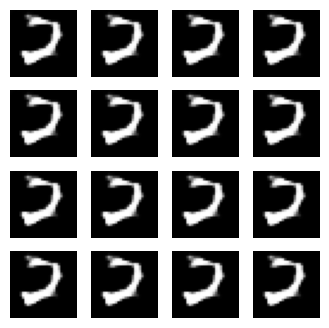

Time for epoch 62 is 12.23 sec


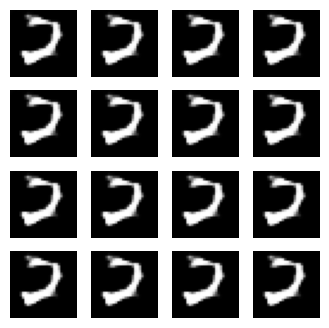

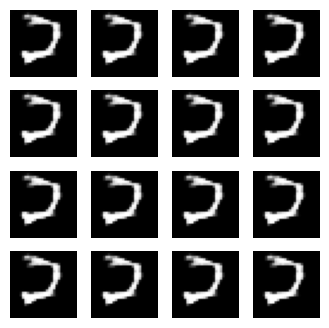

Time for epoch 63 is 12.50 sec


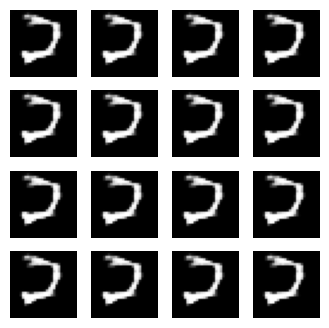

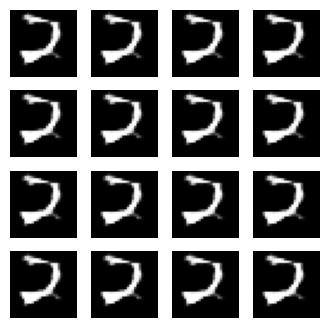

Time for epoch 64 is 12.45 sec


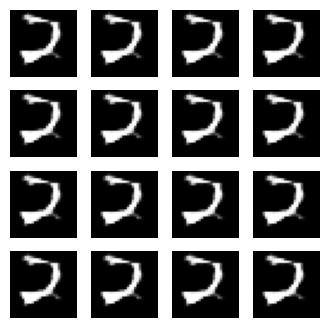

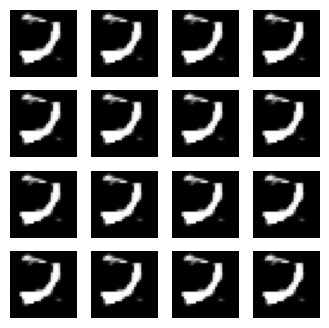

Time for epoch 65 is 12.32 sec


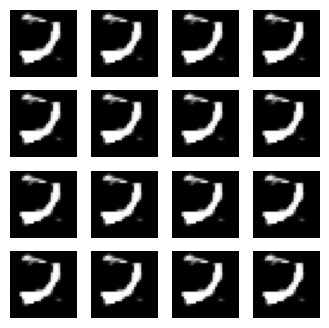

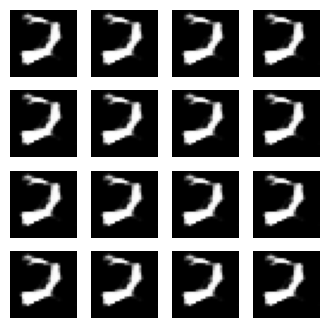

Time for epoch 66 is 12.25 sec


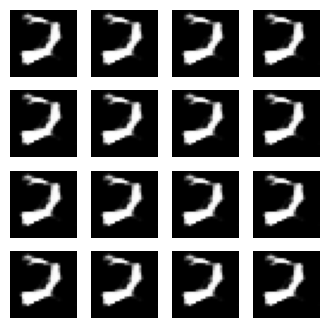

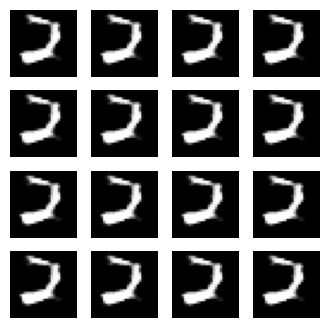

Time for epoch 67 is 12.24 sec


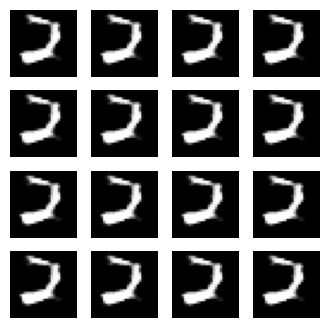

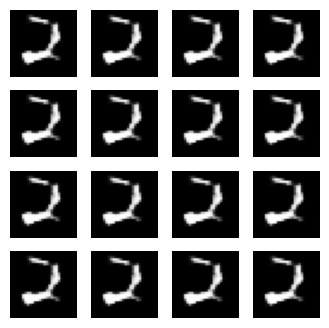

Time for epoch 68 is 12.21 sec


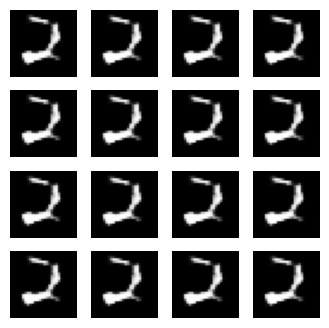

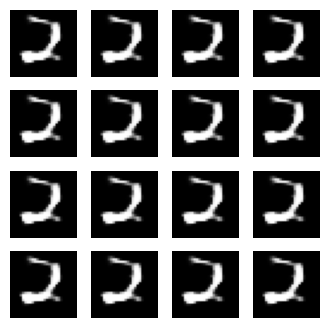

Time for epoch 69 is 12.23 sec


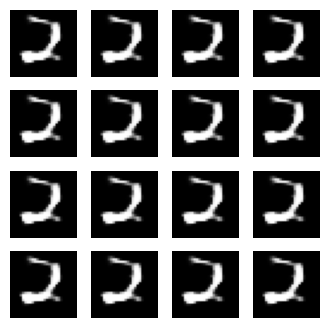

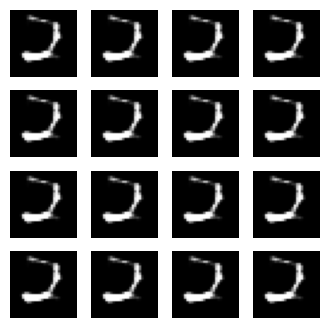

Time for epoch 70 is 12.20 sec


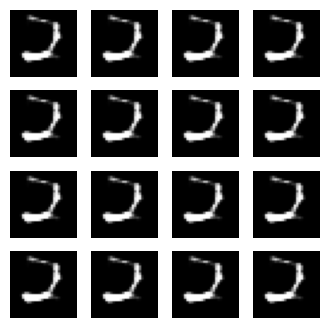

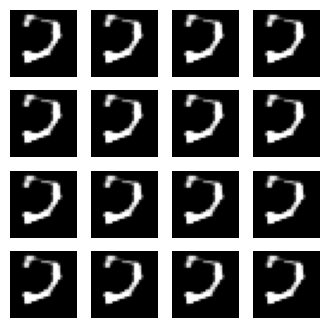

Time for epoch 71 is 12.48 sec


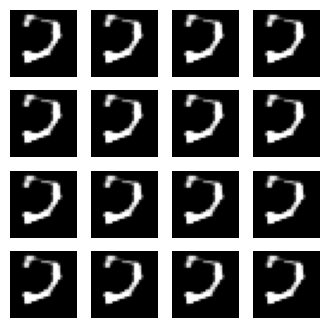

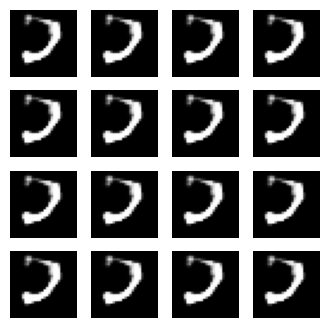

Time for epoch 72 is 12.23 sec


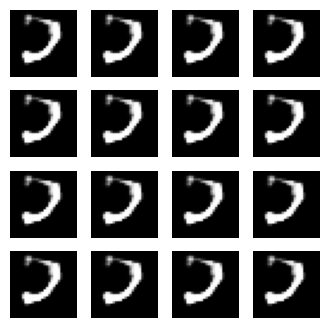

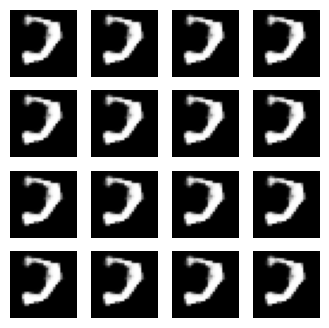

Time for epoch 73 is 12.49 sec


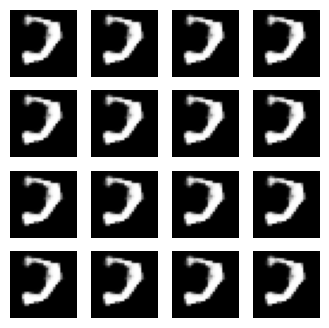

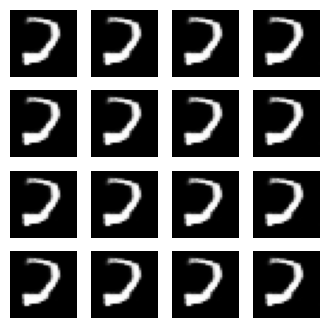

Time for epoch 74 is 12.25 sec


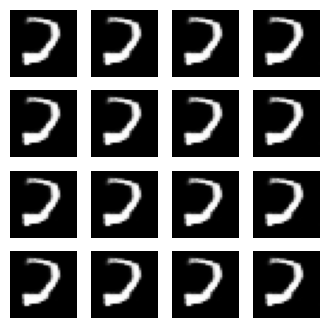

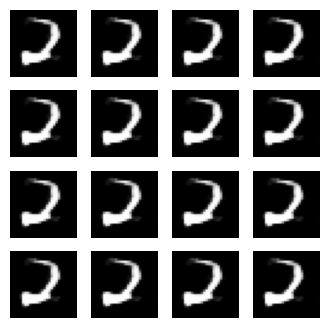

Time for epoch 75 is 12.62 sec


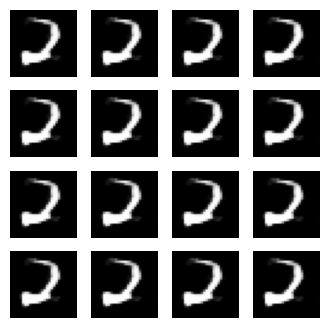

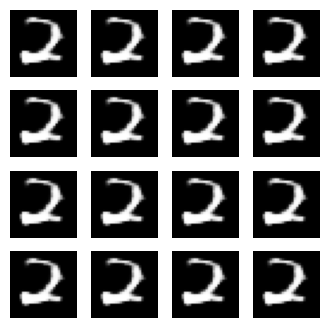

Time for epoch 76 is 12.21 sec


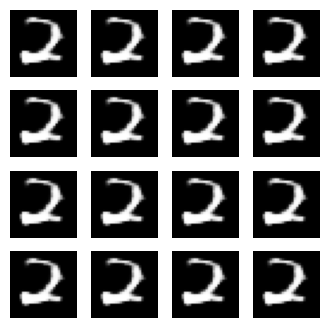

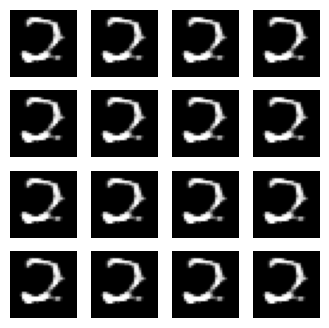

Time for epoch 77 is 12.22 sec


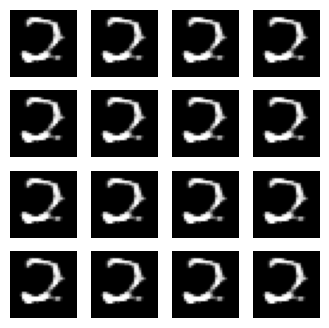

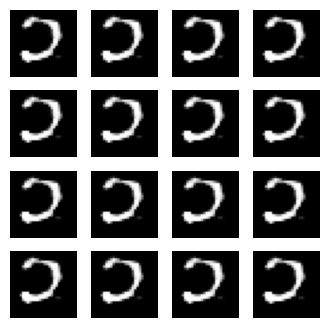

Time for epoch 78 is 12.22 sec


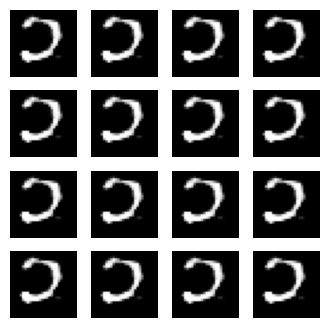

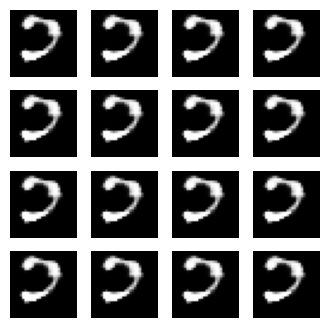

Time for epoch 79 is 12.41 sec


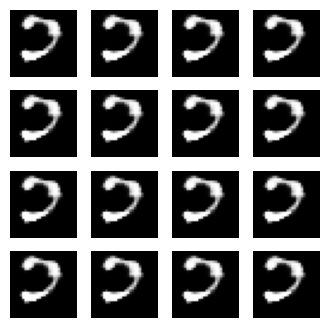

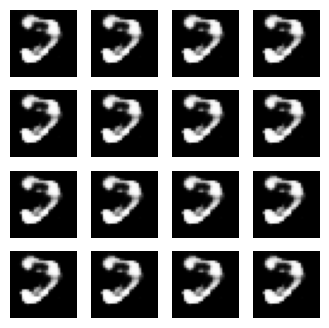

Time for epoch 80 is 12.54 sec


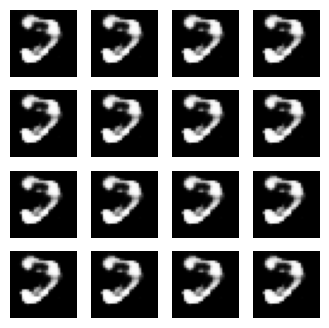

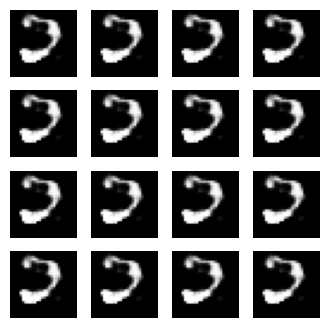

Time for epoch 81 is 12.30 sec


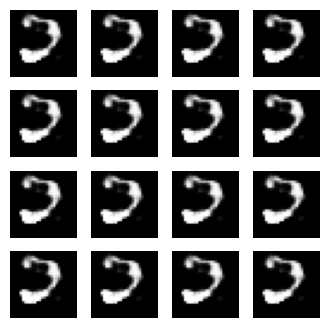

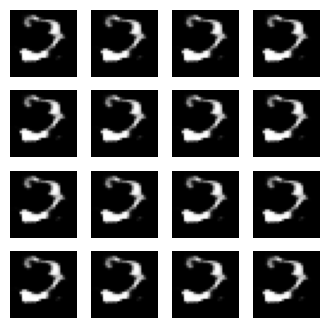

Time for epoch 82 is 12.25 sec


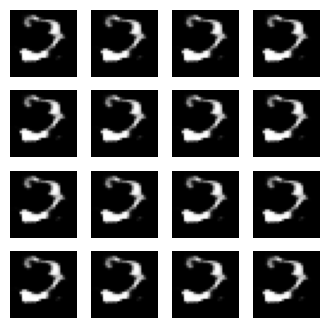

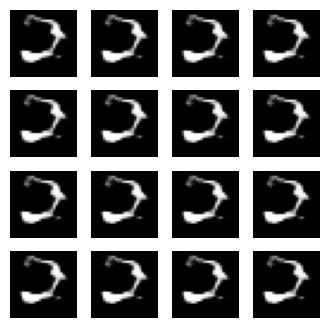

Time for epoch 83 is 12.19 sec


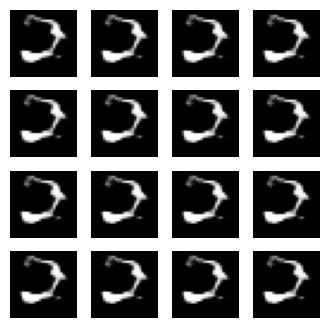

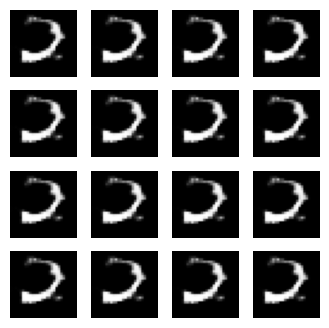

Time for epoch 84 is 12.20 sec


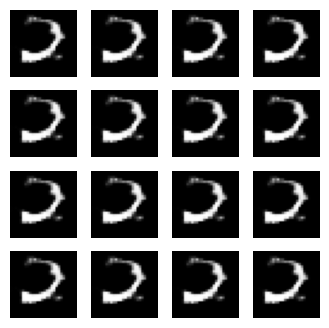

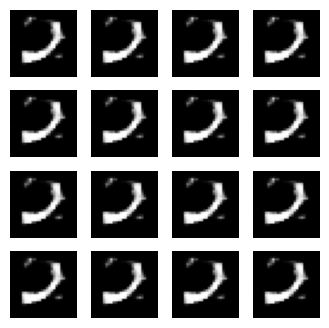

Time for epoch 85 is 12.25 sec


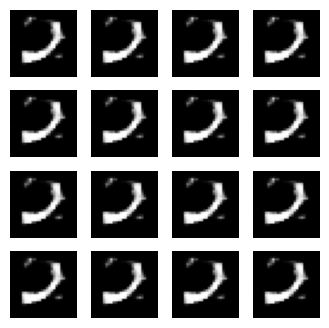

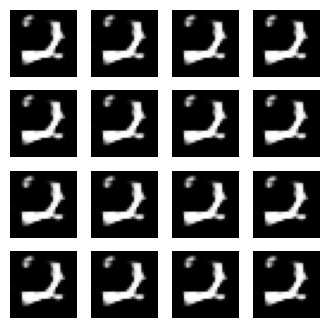

Time for epoch 86 is 12.22 sec


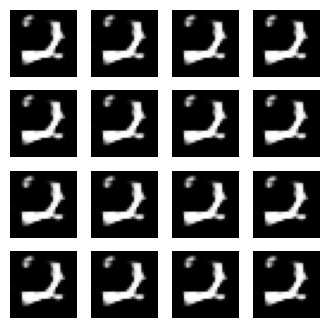

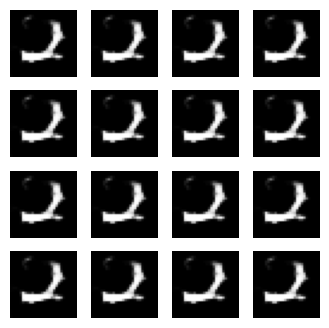

Time for epoch 87 is 12.26 sec


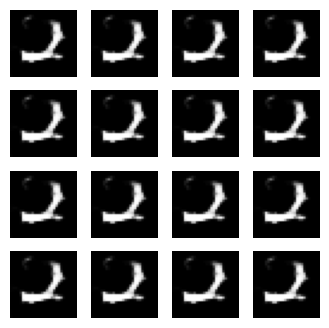

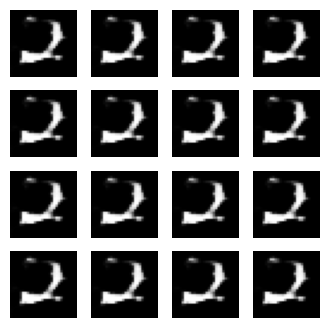

Time for epoch 88 is 12.50 sec


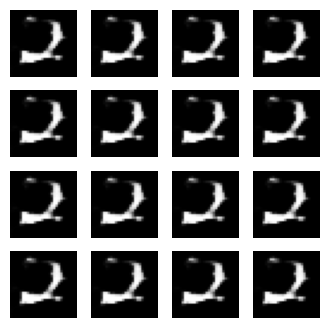

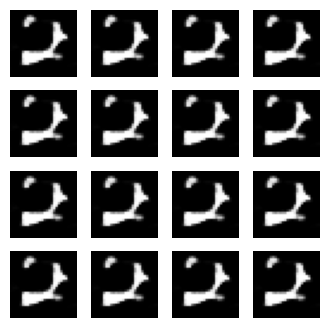

Time for epoch 89 is 12.20 sec


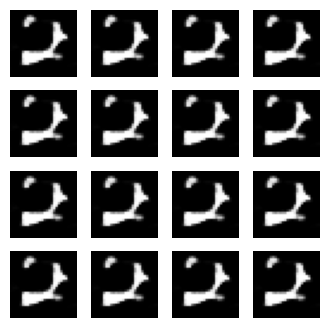

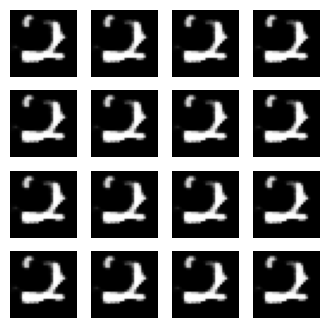

Time for epoch 90 is 12.64 sec


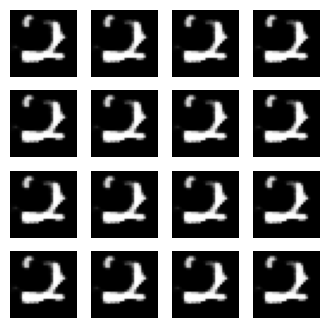

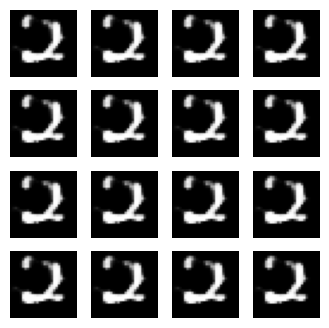

Time for epoch 91 is 12.21 sec


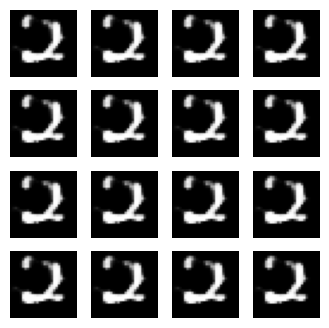

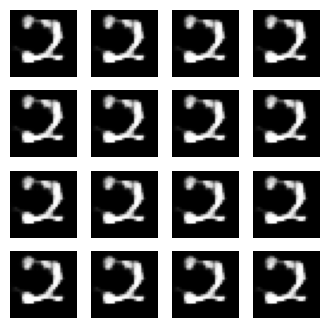

Time for epoch 92 is 12.48 sec


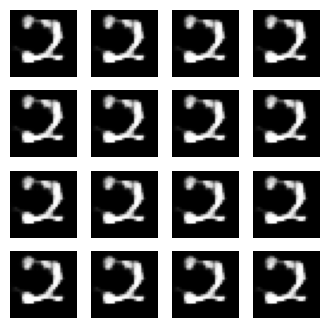

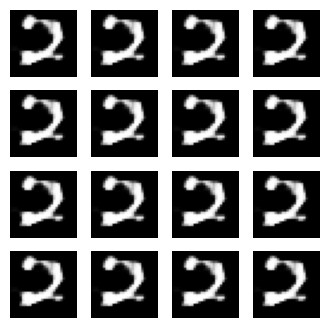

Time for epoch 93 is 12.27 sec


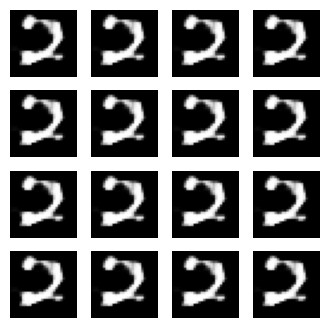

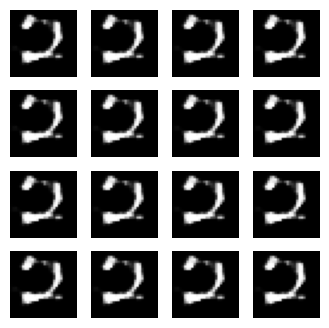

Time for epoch 94 is 12.78 sec


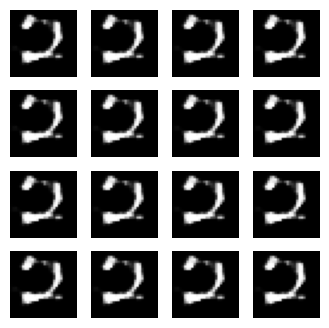

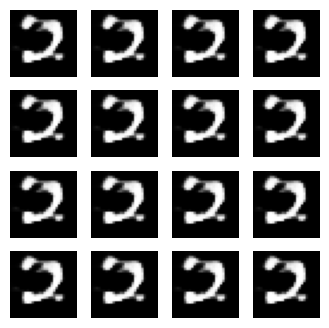

Time for epoch 95 is 12.55 sec


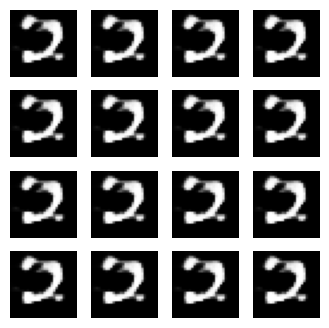

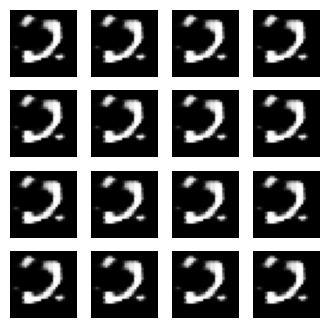

Time for epoch 96 is 12.85 sec


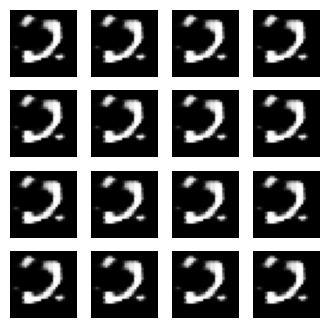

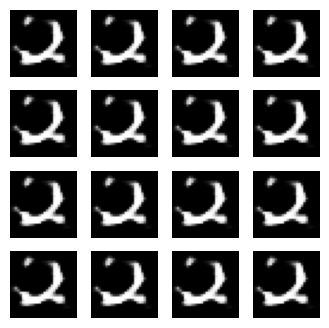

Time for epoch 97 is 12.23 sec


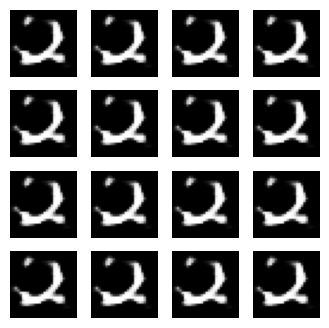

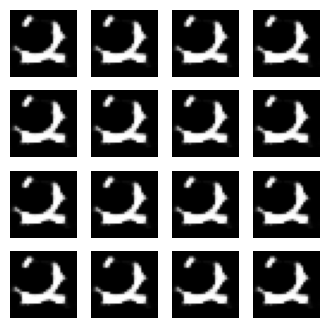

Time for epoch 98 is 12.25 sec


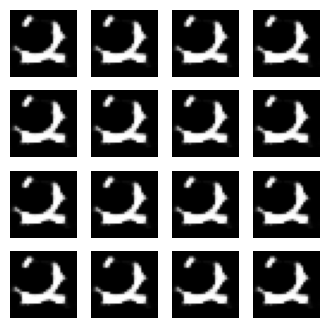

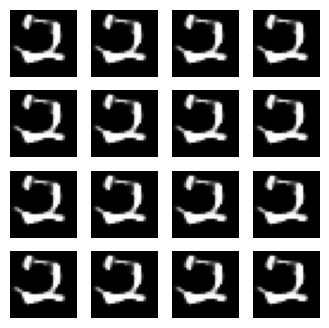

Time for epoch 99 is 12.22 sec


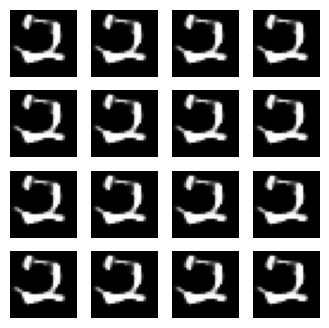

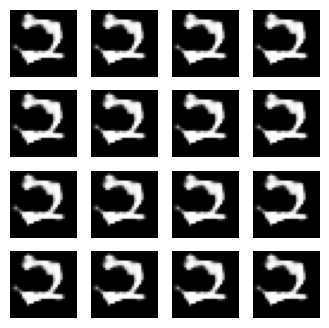

Time for epoch 100 is 12.25 sec


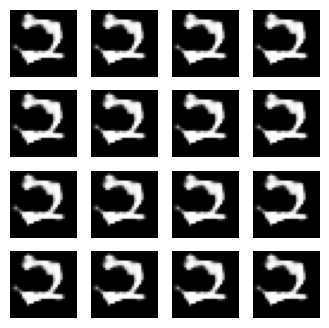

In [27]:
# Start training the GAN
train(train_dataset, EPOCHS)

In [28]:
# Restore the latest checkpoint
# This can be used to resume training or generate images from a saved model
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

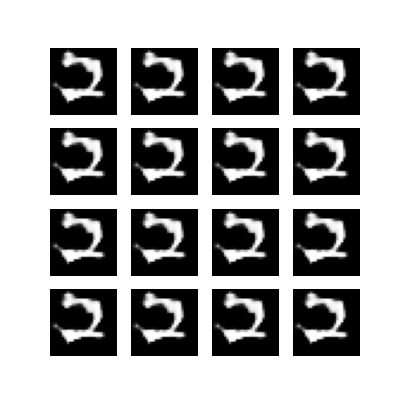

In [29]:
# Function to display a single image generated after a specific epoch
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

# Display the image generated after the final epoch
display_image(EPOCHS)

In [30]:
# Create an animated GIF of the generated images over epochs
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    # Get the list of image files generated during training
    filenames = glob.glob('image_at_epoch_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    # Append the last image multiple times for a pause at the end
    for _ in range(10):
        writer.append_data(image)

<ipython-input-30-283ca4287b8c>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


###**Save Generator Model**

In [31]:
# Save the trained generator model in Keras H5 format
generator.save('generator_model_final.keras')
print("Generator model saved to 'generator_model.h5'")

Generator model saved to 'generator_model.h5'


##**Load the model and generate Images**

- Generate new images using traiend generator.
- Load the generator.
- Create random noise vectores.
- Pass the vector to the generator.
- Save the output.

Generator model loaded successfully.


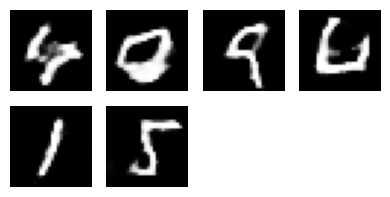

In [32]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the saved generator model
generator_trained = tf.keras.models.load_model('generator_model_final.keras')
print("Generator model loaded successfully.")

# Function to generate and display images
def generate_images(generator, num_images=6, noise_dim=100):
    # Generate random noise vectors
    noise = tf.random.normal([num_images, noise_dim])

    # Generate images using the loaded generator
    generated_images = generator(noise, training=False)

    # Rescale images from [-1, 1] to [0, 1] for display
    generated_images = (generated_images + 1) / 2.0

    # Plot the generated images
    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate and display images
generate_images(generator_trained)